In [18]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
df = pd.read_excel('data_1000_samples_clean.xlsx')
df

,Time,Temp,Weather,Wind,Humidity,Barometer,Visibility,Day,Month,Year
0,12:00 SA,22,Passing clouds.,4,88,1016,100,1,3,2022
1,12:30 SA,22,Passing clouds.,4,88,1015,100,1,3,2022
2,1:00 SA,22,Passing clouds.,4,83,1015,100,1,3,2022
3,1:30 SA,21,Passing clouds.,4,88,1015,8,1,3,2022
4,2:00 SA,21,Passing clouds.,2,88,1015,8,1,3,2022
...,...,...,...,...,...,...,...,...,...,...
996,5:00 CH,28,Passing clouds.,19,79,1009,100,22,3,2022
997,5:30 CH,28,Passing clouds.,13,79,1009,100,22,3,2022
998,6:00 CH,27,Passing clouds.,11,84,1009,100,22,3,2022
999,6:30 CH,27,Passing clouds.,11,84,1009,100,22,3,2022


In [20]:
train_df = df[['Temp','Wind','Humidity','Barometer']][200:248]
val_df = df[['Temp','Wind','Humidity','Barometer']][248:296]
test_df = df[['Temp','Wind','Humidity','Barometer']][248:296]

In [21]:
# train_mean = train_df.mean()
# train_std = train_df.std()

# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

### Feature Engineering: Window Features

In [22]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns # = ['Temp','Wind','Humidity','Barometer']
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)} #chỉ số label
        #{'Temp': 0, 'Wind': 1, 'Humidity': 2, 'Barometer': 3}
        
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)} 
        #{'Temp': 0, 'Wind': 1, 'Humidity': 2, 'Barometer': 3}

        self.input_width = input_width # = 24
        self.label_width = label_width # = 24
        self.shift = shift # = 24

        self.total_window_size = input_width + shift # = 48

        self.input_slice = slice(0, input_width) # slice(0, 24)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice] # np.arange(48)[slice(0, 24)]

        self.label_start = self.total_window_size - self.label_width # = 24
        self.labels_slice = slice(self.label_start, None) # slice(24, 48)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice] # np.arange(48)[slice(24, 48)]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])

    def train(self):
        return self.make_dataset(self.train_df)

    def val(self):
        return self.make_dataset(self.val_df)

    def test(self):
        return self.make_dataset(self.test_df)

In [23]:
# Hàm chia input và output
def split_window(self, features):
    #Chia dữ liệu thành 2 inputs và labels
    inputs = features[:, self.input_slice, :] #input_slice = slice(0, 24)
    labels = features[:, self.labels_slice, :] #labels_slice = slice(24, 48)
    
    #Lấy dữ liệu dựa trên label
    if self.label_columns is not None:
        # label_columns = ['Temp','Wind','Humidity','Barometer']
        # column_indices[Temp] = 0 ; column_indices[Wind] = 1;... 
        labels = tf.stack( [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window


In [24]:

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32) # chuyển dataframe về numpy array
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)
    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [25]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    result = getattr(self, '_example', None)
    if result is None:
        result = next(iter(self.test))
        self._example = result
    return result

In [26]:
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [27]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                              train_df = train_df,
                              val_df = val_df,
                              test_df = test_df,
                              label_columns = ['Temp','Wind','Humidity','Barometer'])

In [28]:
multi_window.__repr__()

"Total window size: 48\nInput indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]\nLabel indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]\nLabel column name(s): ['Temp', 'Wind', 'Humidity', 'Barometer']"

## Training

In [41]:
import tensorflow as tf
from sklearn.metrics import r2_score
MAX_EPOCHS = 200

def mean_2(y_true, y_pred):
    MSE = tf.reduce_mean(tf.square(y_true - y_pred))

    y_sub = tf.subtract(y_true[:, 1:, :], y_true[:, :-1, :])
    y_hat_sub = tf.subtract(y_pred[:, 1:, :], y_pred[:, :-1, :])

    n = y_sub.shape[1] + y_sub.shape[2]
    
    A = y_sub*y_hat_sub + 1
    B = tf.sqrt(tf.square(y_sub) + 1)*tf.sqrt(tf.square(y_hat_sub) + 1)
    
    alpha = 0.7
    
    vector_similarity = tf.abs(tf.divide(A,B))
    sum_VS = tf.reduce_mean(vector_similarity)
    sum_VS = sum_VS*alpha

    
    MSE_2 = MSE - sum_VS
    
    return MSE_2


def compile_and_fit(model, window, patience=2):

    model.compile(loss=mean_2,
                  optimizer=tf.optimizers.Adam(),
                  metrics=[mean_2,tf.metrics.MeanAbsoluteError()])
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val)
    return history


In [42]:
num_features = train_df.shape[1]
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -12:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),

    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [43]:
history = compile_and_fit(multi_conv_model, multi_window)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 257830.4531 - mean_2: 257830.4531 - mean_absolute_error: 281.8021 - val_loss: 214260.9062 - val_mean_2: 214260.9062 - val_mean_absolute_error: 271.4195
Epoch 2/200
1/1 [==============================] - 0s 50ms/step - loss: 213205.1094 - mean_2: 213205.1094 - mean_absolute_error: 271.6864 - val_loss: 168411.4219 - val_mean_2: 168411.4219 - val_mean_absolute_error: 233.5905
Epoch 3/200
1/1 [==============================] - 0s 49ms/step - loss: 167504.6250 - mean_2: 167504.6250 - mean_absolute_error: 233.9088 - val_loss: 127392.8984 - val_mean_2: 127392.8984 - val_mean_absolute_error: 212.9871
Epoch 4/200
1/1 [==============================] - 0s 48ms/step - loss: 126588.6562 - mean_2: 126588.6562 - mean_absolute_error: 212.1356 - val_loss: 90153.0391 - val_mean_2: 90153.0391 - val_mean_absolute_error: 188.2382
Epoch 5/200
1/1 [==============================] - 0s 49ms/step - loss: 89486.2344 - mean_2: 89486.2344 - me

Epoch 39/200
1/1 [==============================] - 0s 47ms/step - loss: 441.1765 - mean_2: 441.1765 - mean_absolute_error: 14.5692 - val_loss: 856.8604 - val_mean_2: 856.8604 - val_mean_absolute_error: 19.4078
Epoch 40/200
1/1 [==============================] - 0s 48ms/step - loss: 890.2937 - mean_2: 890.2937 - mean_absolute_error: 20.5180 - val_loss: 1259.2335 - val_mean_2: 1259.2335 - val_mean_absolute_error: 22.0457
Epoch 41/200
1/1 [==============================] - 0s 46ms/step - loss: 1297.8422 - mean_2: 1297.8422 - mean_absolute_error: 23.3373 - val_loss: 1528.8448 - val_mean_2: 1528.8448 - val_mean_absolute_error: 22.5853
Epoch 42/200
1/1 [==============================] - 0s 46ms/step - loss: 1562.6378 - mean_2: 1562.6378 - mean_absolute_error: 23.3310 - val_loss: 1628.0431 - val_mean_2: 1628.0431 - val_mean_absolute_error: 23.3058
Epoch 43/200
1/1 [==============================] - 0s 46ms/step - loss: 1650.7007 - mean_2: 1650.7007 - mean_absolute_error: 23.0079 - val_loss: 

1/1 [==============================] - 0s 45ms/step - loss: 21.4778 - mean_2: 21.4778 - mean_absolute_error: 3.0632 - val_loss: 44.7590 - val_mean_2: 44.7590 - val_mean_absolute_error: 4.7568
Epoch 79/200
1/1 [==============================] - 0s 46ms/step - loss: 30.7320 - mean_2: 30.7320 - mean_absolute_error: 3.4681 - val_loss: 50.5832 - val_mean_2: 50.5832 - val_mean_absolute_error: 4.9263
Epoch 80/200
1/1 [==============================] - 0s 45ms/step - loss: 35.2714 - mean_2: 35.2714 - mean_absolute_error: 3.6188 - val_loss: 51.2240 - val_mean_2: 51.2240 - val_mean_absolute_error: 5.0789
Epoch 81/200
1/1 [==============================] - 0s 47ms/step - loss: 34.3250 - mean_2: 34.3250 - mean_absolute_error: 3.5958 - val_loss: 46.5928 - val_mean_2: 46.5928 - val_mean_absolute_error: 5.0260
Epoch 82/200
1/1 [==============================] - 0s 44ms/step - loss: 28.6753 - mean_2: 28.6753 - mean_absolute_error: 3.2999 - val_loss: 37.8717 - val_mean_2: 37.8717 - val_mean_absolute_er

1/1 [==============================] - 0s 47ms/step - loss: -2.3243 - mean_2: -2.3243 - mean_absolute_error: 0.2709 - val_loss: 8.3760 - val_mean_2: 8.3760 - val_mean_absolute_error: 2.0004
Epoch 119/200
1/1 [==============================] - 0s 47ms/step - loss: -2.4336 - mean_2: -2.4336 - mean_absolute_error: 0.1414 - val_loss: 8.4991 - val_mean_2: 8.4991 - val_mean_absolute_error: 2.0615
Epoch 120/200
1/1 [==============================] - 0s 44ms/step - loss: -2.4201 - mean_2: -2.4201 - mean_absolute_error: 0.1727 - val_loss: 8.7426 - val_mean_2: 8.7426 - val_mean_absolute_error: 2.1288
Epoch 121/200
1/1 [==============================] - 0s 46ms/step - loss: -2.3094 - mean_2: -2.3094 - mean_absolute_error: 0.2708 - val_loss: 9.0195 - val_mean_2: 9.0195 - val_mean_absolute_error: 2.2082
Epoch 122/200
1/1 [==============================] - 0s 45ms/step - loss: -2.1668 - mean_2: -2.1668 - mean_absolute_error: 0.3458 - val_loss: 9.2980 - val_mean_2: 9.2980 - val_mean_absolute_error: 2

1/1 [==============================] - 0s 46ms/step - loss: -2.4151 - mean_2: -2.4151 - mean_absolute_error: 0.0837 - val_loss: 8.3402 - val_mean_2: 8.3402 - val_mean_absolute_error: 2.0069
Epoch 159/200
1/1 [==============================] - 0s 45ms/step - loss: -2.4152 - mean_2: -2.4152 - mean_absolute_error: 0.0661 - val_loss: 8.3126 - val_mean_2: 8.3126 - val_mean_absolute_error: 2.0093
Epoch 160/200
1/1 [==============================] - 0s 46ms/step - loss: -2.4203 - mean_2: -2.4203 - mean_absolute_error: 0.0705 - val_loss: 8.4176 - val_mean_2: 8.4176 - val_mean_absolute_error: 2.0283
Epoch 161/200
1/1 [==============================] - 0s 45ms/step - loss: -2.4180 - mean_2: -2.4180 - mean_absolute_error: 0.0837 - val_loss: 8.4086 - val_mean_2: 8.4086 - val_mean_absolute_error: 2.0327
Epoch 162/200
1/1 [==============================] - 0s 46ms/step - loss: -2.4108 - mean_2: -2.4108 - mean_absolute_error: 0.0968 - val_loss: 8.4800 - val_mean_2: 8.4800 - val_mean_absolute_error: 2

1/1 [==============================] - 0s 46ms/step - loss: -2.3822 - mean_2: -2.3822 - mean_absolute_error: 0.0871 - val_loss: 8.3758 - val_mean_2: 8.3758 - val_mean_absolute_error: 2.0217
Epoch 199/200
1/1 [==============================] - 0s 45ms/step - loss: -2.3759 - mean_2: -2.3759 - mean_absolute_error: 0.0916 - val_loss: 8.3457 - val_mean_2: 8.3457 - val_mean_absolute_error: 2.0208
Epoch 200/200
1/1 [==============================] - 0s 47ms/step - loss: -2.3579 - mean_2: -2.3579 - mean_absolute_error: 0.1006 - val_loss: 8.4034 - val_mean_2: 8.4034 - val_mean_absolute_error: 2.0324


In [32]:
multi_conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 12, 4)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 256)           3328      
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 dense_1 (Dense)             (None, 96)                245856    
                                                                 
 reshape_1 (Reshape)         (None, 24, 4)             0         
                                                                 
Total params: 249,184
Trainable params: 249,184
Non-trainable params: 0
_________________________________________________________________


## Trực quan dữ liệu sau khi Training

In [33]:
def plot(self, model=None, plot_col='Temp', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(19, 3))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col}')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot


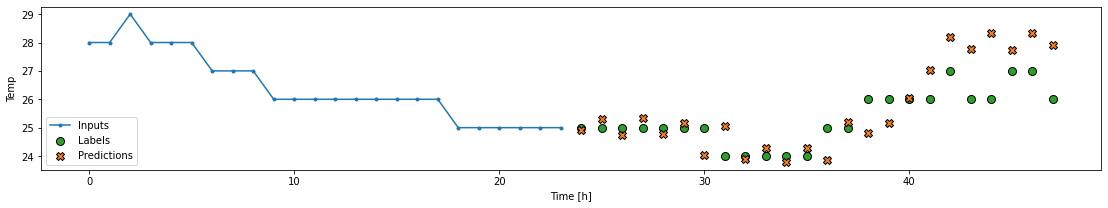

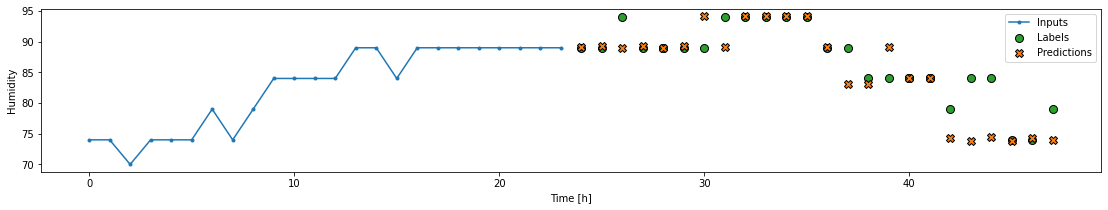

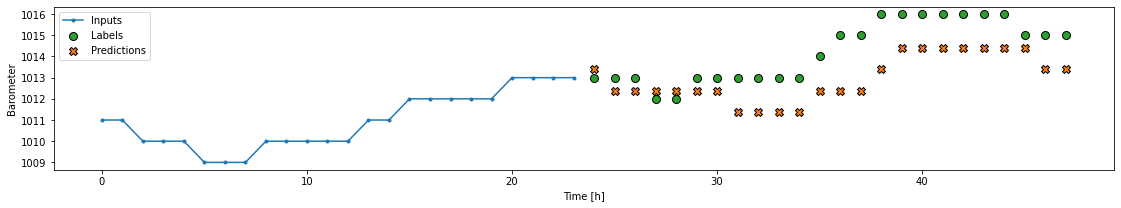

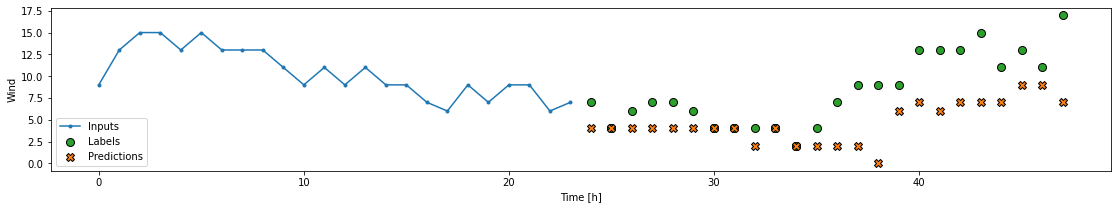

In [34]:
multi_window.plot(multi_conv_model,plot_col='Temp')
multi_window.plot(multi_conv_model,plot_col='Humidity')
multi_window.plot(multi_conv_model,plot_col='Barometer')
multi_window.plot(multi_conv_model,plot_col='Wind')